In [1]:
import os
import time
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_v2_s
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

In [2]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [8]:
# Paths
data_path = "/kaggle/input/preprocessed-dr-dataset9-4-25"
train_dir = os.path.join(data_path, "train")
val_dir = os.path.join(data_path, "val")
test_dir = os.path.join(data_path, "test")


In [9]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [10]:
# Datasets & Loaders
train_data = ImageFolder(train_dir, transform=transform)
val_data = ImageFolder(val_dir, transform=transform)
test_data = ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)


In [11]:
# Model
model = efficientnet_v2_s(weights='DEFAULT')
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 5)
model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 221MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

Epoch [1/10], Train Loss: 0.9183, Acc: 62.23%, Val Loss: 0.8610, Val Acc: 67.34%


Epoch [2/10], Train Loss: 0.5318, Acc: 79.27%, Val Loss: 0.9495, Val Acc: 67.77%


Epoch [3/10], Train Loss: 0.3053, Acc: 88.71%, Val Loss: 1.2679, Val Acc: 65.11%


Epoch [4/10], Train Loss: 0.1889, Acc: 93.27%, Val Loss: 1.3035, Val Acc: 66.11%


Epoch [5/10], Train Loss: 0.1334, Acc: 95.18%, Val Loss: 1.5594, Val Acc: 66.50%


Epoch [6/10], Train Loss: 0.1057, Acc: 96.27%, Val Loss: 1.5520, Val Acc: 66.59%


Epoch [7/10], Train Loss: 0.0939, Acc: 96.69%, Val Loss: 1.5376, Val Acc: 67.05%


Epoch [8/10], Train Loss: 0.0774, Acc: 97.22%, Val Loss: 1.5559, Val Acc: 67.51%


Epoch [9/10], Train Loss: 0.0737, Acc: 97.45%, Val Loss: 1.7970, Val Acc: 66.20%


Epoch [10/10], Train Loss: 0.0639, Acc: 97.84%, Val Loss: 1.9178, Val Acc: 66.50%


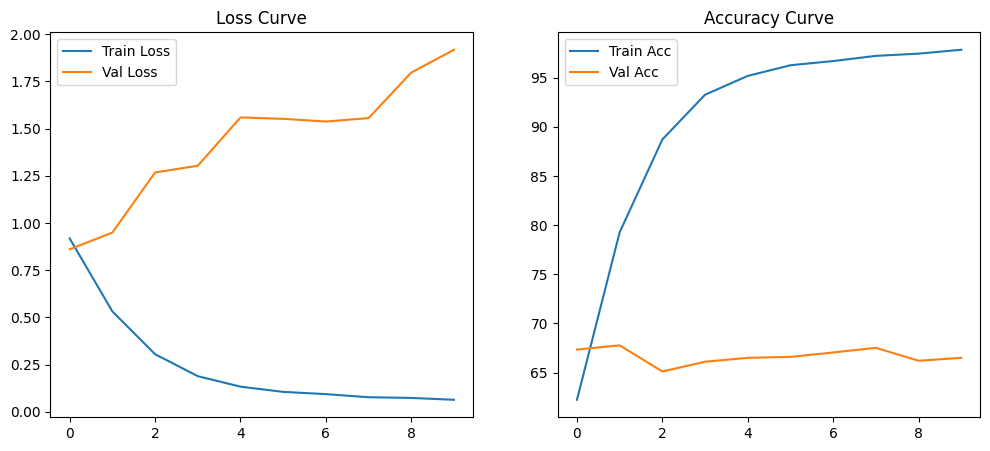

Inference Latency on test set: 18.78 seconds


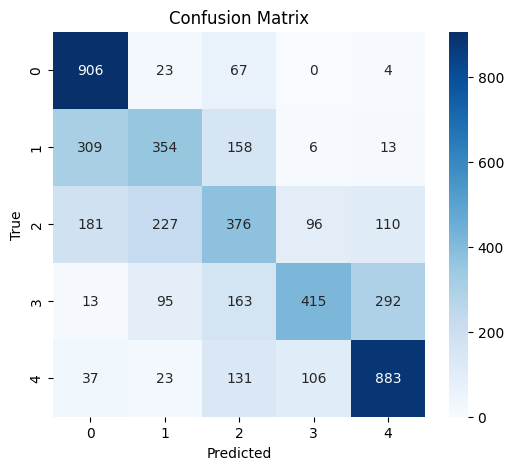

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.63      0.91      0.74      1000
     Class 1       0.49      0.42      0.45       840
     Class 2       0.42      0.38      0.40       990
     Class 3       0.67      0.42      0.52       978
     Class 4       0.68      0.75      0.71      1180

    accuracy                           0.59      4988
   macro avg       0.58      0.58      0.56      4988
weighted avg       0.58      0.59      0.57      4988



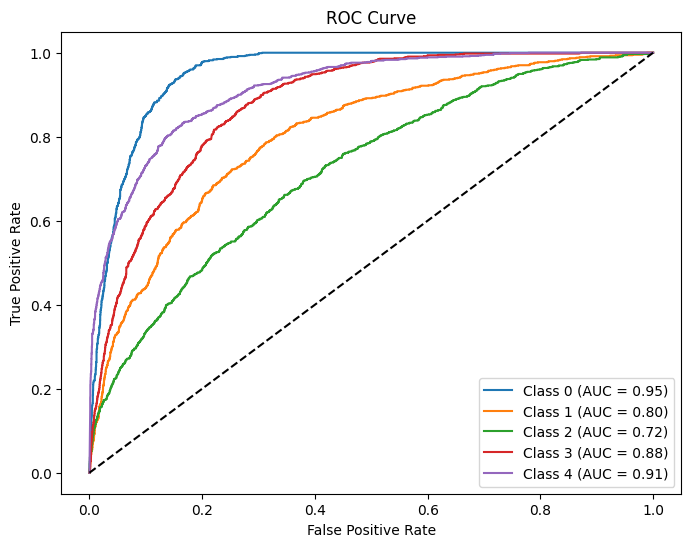

In [15]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

        loop.set_postfix(loss=loss.item())

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)

            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += loss.item()

    val_acc = 100 * val_correct / val_total
    val_loss /= len(val_loader)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Plot Loss & Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_hist, label='Train Acc')
plt.plot(val_acc_hist, label='Val Acc')
plt.title("Accuracy Curve")
plt.legend()
plt.show()

# Evaluation
model.eval()
all_preds, all_labels, all_probs = [], [], []

start = time.time()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.numpy())

end = time.time()
latency = end - start
print(f"Inference Latency on test set: {latency:.2f} seconds")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(5)]))

# ROC Curve
fpr, tpr, roc_auc = {}, {}, {}
y_true_one_hot = np.eye(5)[all_labels]

for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], np.array(all_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='lower right')
plt.show()

In [17]:
from IPython.display import FileLink

# Re-define model_path if not already done
model_path = "efficientnet_dr_model.pth"

# Save the model (if not saved already)
torch.save(model.state_dict(), model_path)

# Generate download link
FileLink(model_path)


/kaggle/working/efficientnet_dr_model.pth